# Multiclass semantic segmentation using DeepLabV3+
https://keras.io/examples/vision/deeplabv3_plus/

## Dataset
Rellis-3D grupped in **6 categories**

https://arxiv.org/abs/1811.12596

### Environment tf39

In [1]:
import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras import ops
#from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

# For data preprocessing
import tensorflow as tf
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io


In [2]:
print(keras.__version__)
print(tf.__version__)

3.0.5
2.16.1


In [3]:
#!pip install tensorflow
!pip check tensorflow

No broken requirements found.


## Creating a TensorFlow Dataset
Training on the entire RELLIS-3D dataset gropued in 6 categories.

In [5]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 6
TRAIN_DIR = "./rellis6/train"
VALID_DIR = "./rellis6/val"

train_images = sorted(glob(os.path.join(TRAIN_DIR, "images/*")))
train_masks = sorted(glob(os.path.join(TRAIN_DIR, "masks_id/*")))
val_images = sorted(glob(os.path.join(VALID_DIR, "images/*")))
val_masks = sorted(glob(os.path.join(VALID_DIR, "masks_id/*")))

print(len(train_images))
print(len(train_masks))
print(len(val_images))
print(len(val_masks))

3302
3302
983
983


In [6]:
def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf_image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


## Building the DeepLabV3+ model
**DeepLabv3+** amplía DeepLabv3 agregando una estructura codificador-decodificador (decoder-encoder). El módulo codificador procesa información contextual multiescala aplicando convolución dilatada en múltiples escalas, mientras que el módulo decodificador refina los resultados de la segmentación a lo largo de los límites del objeto.

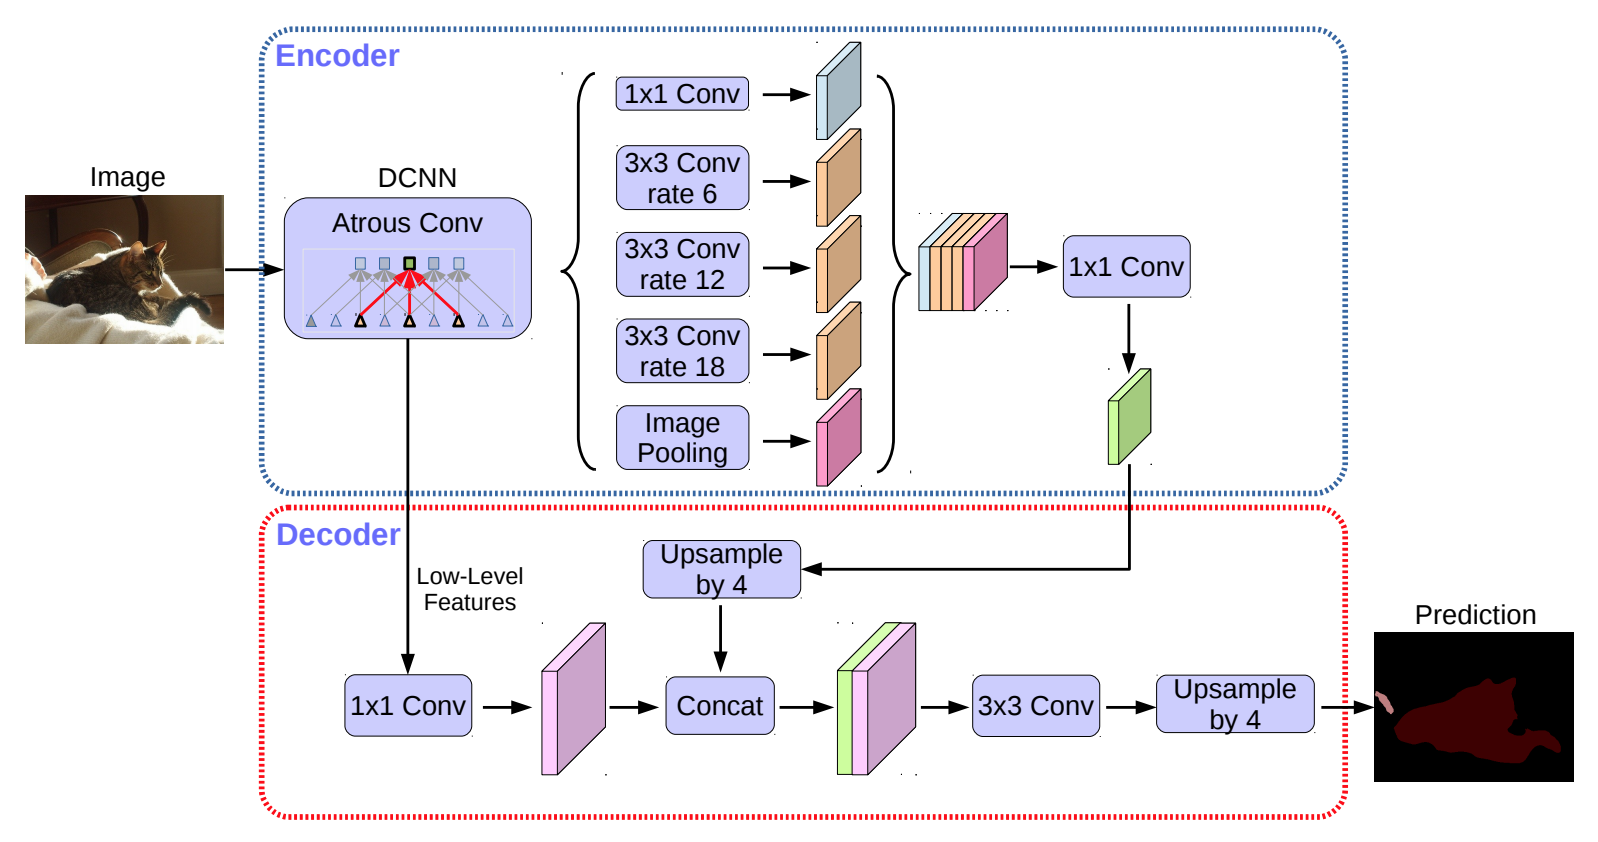

**Convolución dilatada**: con la convolución dilatada, a medida que profundizamos en la red, podemos mantener el paso constante pero con un campo de visión más amplio sin aumentar la cantidad de parámetros o la cantidad de cálculo. Además, permite mapas de características de salida más grandes, lo cual es útil para la segmentación semántica.

La razón para utilizar la **agrupación de pirámides espaciales dilatadas** es que se demostró que a medida que la tasa de muestreo aumenta, la cantidad de ponderaciones de filtro válidas (es decir, ponderaciones que se aplican a la región de características válida, en lugar de ceros rellenos) se reduce.

In [7]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

Las características del encoder primero se muestrean bilinealmente mediante un factor 4 y luego se concatenan con las características de bajo nivel correspondientes de la red troncal que tienen la misma resolución espacial. Para este ejemplo, utilizamos un ResNet50 previamente entrenado en ImageNet como modelo de red troncal y utilizamos las funciones de bajo nivel del bloque conv4_block6_2_relu de la red troncal.

In [8]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    #preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    preprocessed = preprocess_input(model_input)
    #resnet50 = keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessed)
    resnet50 = ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessed)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 512, 512)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 512, 512)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 512, 512)  │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 512, 512,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512, 512,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c

 Total params: 11,853,638 (45.22 MB)

 Trainable params: 11,820,902 (45.09 MB)

 Non-trainable params: 32,736 (127.88 KB)

## Training
Entrenamos el modelo utilizando entropía cruzada categórica dispersa como función de pérdida y Adam como optimizador.

### Training with Accuracy Metrics

Epoch 1/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 4736s 6s/step - accuracy: 0.9574 - loss: 0.1176 - val_accuracy: 0.6266 - val_loss: 12.0154
Epoch 2/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 4426s 5s/step - accuracy: 0.9634 - loss: 0.1088 - val_accuracy: 0.7740 - val_loss: 2.5928
Epoch 3/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 4499s 5s/step - accuracy: 0.9666 - loss: 0.0938 - val_accuracy: 0.8202 - val_loss: 0.8673
Epoch 4/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 4468s 5s/step - accuracy: 0.9687 - loss: 0.0862 - val_accuracy: 0.8037 - val_loss: 1.5640
Epoch 5/5
825/825 ━━━━━━━━━━━━━━━━━━━━ 4468s 5s/step - accuracy: 0.9707 - loss: 0.0797 - val_accuracy: 0.8382 - val_loss: 1.7656


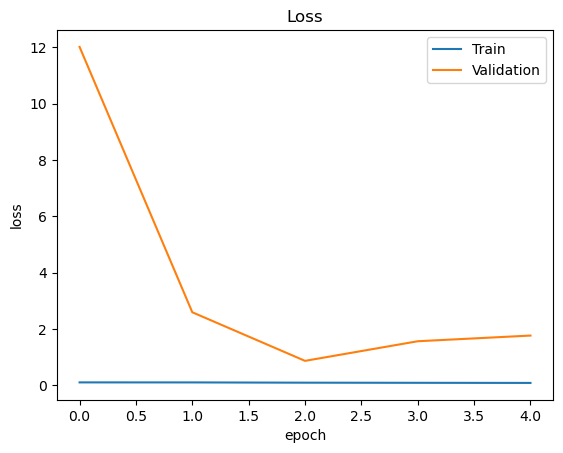

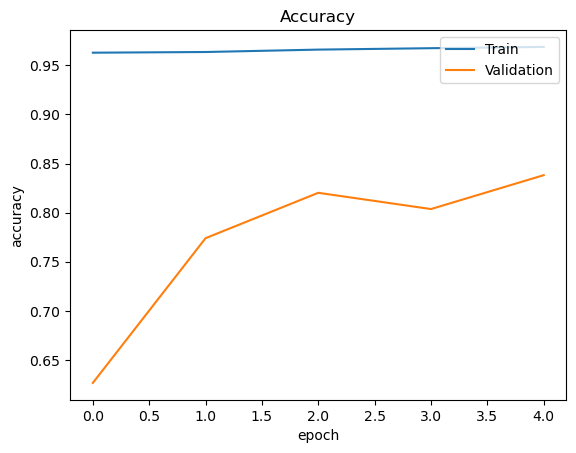

In [9]:
num_epochs = 5
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

## Guardar modelo completo

In [10]:
tf.saved_model.save(model, './model/Test_4.1_DeepLabV3+_Rellis6')


INFO:tensorflow:Assets written to: ./model/Test_4.1_DeepLabV3+_Rellis6\assets


INFO:tensorflow:Assets written to: ./model/Test_4.1_DeepLabV3+_Rellis6\assets


## Inferencia mediante superposición de mapa de colores
Las predicciones sin procesar del modelo representan un tensor de forma codificado en caliente (N, 512, 512, num_clases) donde cada uno de los num_clases (canales) es una máscara binaria correspondiente a una etiqueta predicha. Para visualizar los resultados, los trazamos como máscaras de segmentación RGB donde cada píxel está representado por un color único correspondiente a la etiqueta particular predicha. Podemos encontrar fácilmente el color correspondiente a cada etiqueta en el archivo human_colormap.mat proporcionado como parte del conjunto de datos. También trazaríamos una superposición de la máscara de segmentación RGB en la imagen de entrada, ya que esto nos ayuda a identificar las diferentes categorías presentes en la imagen de manera más intuitiva.

### Cargar imágenes de Test

In [11]:
TEST_DIR='./rellis6/test'
test_images = sorted(glob(os.path.join(TEST_DIR, "images/*")))
test_masks = sorted(glob(os.path.join(TEST_DIR, "masks_id/*")))

print(len(test_images))
print(len(test_masks))


1672
1672


In [12]:
## Seleccionar 4 imágenes de Test
# Seleccionar imágenes RGB del conjunto de test
for filename in test_images[:4]:
    print(filename)

./rellis6/test\images\frame000000-1581623790_349.jpg
./rellis6/test\images\frame000000-1581624652_750.jpg
./rellis6/test\images\frame000002-1581623790_549.jpg
./rellis6/test\images\frame000002-1581624652_949.jpg


In [13]:
## Seleccionar los ground Truth (maskcolors) de las imágenes anteriores
# Seleccionar los máscaras GT de las imágenes de test
test_gt = sorted(glob(os.path.join("./rellis6", "GT_test/*")))
print(len(test_gt))
for filename in test_gt[:4]:
    print(filename)

4
./rellis6\GT_test\frame000000-1581623790_349.png
./rellis6\GT_test\frame000000-1581624652_750.png
./rellis6\GT_test\frame000002-1581623790_549.png
./rellis6\GT_test\frame000002-1581624652_949.png


### Estudio del mapa de colores para que coincida con el del dataset original


In [20]:
# Original Label IDs
# IDs =    [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 17, 18, 19, 23, 27, 31, 33, 34]

# Grouped Label IDs
IDs = (0, 1, 2, 3, 4, 5, 6)

# Grouped label names
CLASSES = ("background", "L1 (Smooth)", "L2 (Rough)", "L3 (Bumpy)", "non-Nav (Forbidden)", "obstacle")

# Grouped RGB Colors
PALETTE = np.array([[ 108, 64, 20 ], [ 255, 229, 204 ],[ 0, 102, 0 ],[ 0, 255, 0 ], [ 0, 153, 153 ],[ 0, 128, 255 ]])

In [21]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

In [22]:
# Mostrar RGB vs máscara GT (maskcolor) vs Predicción (máscara superpuesta con PALETTE)
def plot_GTMaskvsPred(images_list, test_gt, mask_gt, model):
    print(test_gt)
    aux=0
    for image_file in images_list:
        image_tensor = read_image(image_file)
        gt_image = read_image(test_gt[aux])        # Ground Truth image
        gt_mask = read_image(mask_gt[aux])         # Ground Truth mask
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, PALETTE, NUM_CLASSES)
        
        #gt_mask_colormap = decode_segmentation_masks(gt_mask, PALETTE, NUM_CLASSES)
        print(gt_mask.shape)
        #overlay = get_overlay(image_tensor, gt_mask_colormap)
        
        #print(gt_mask_colormap.shape)
        plot_samples_matplotlib(
            [image_tensor, gt_image, prediction_colormap], figsize=(18, 14)
        )
        aux+=1

## Inferencia en conjunto Test
Puede utilizar el modelo entrenado alojado en Hugging Face Hub y probar la demostración en Hugging Face Spaces.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


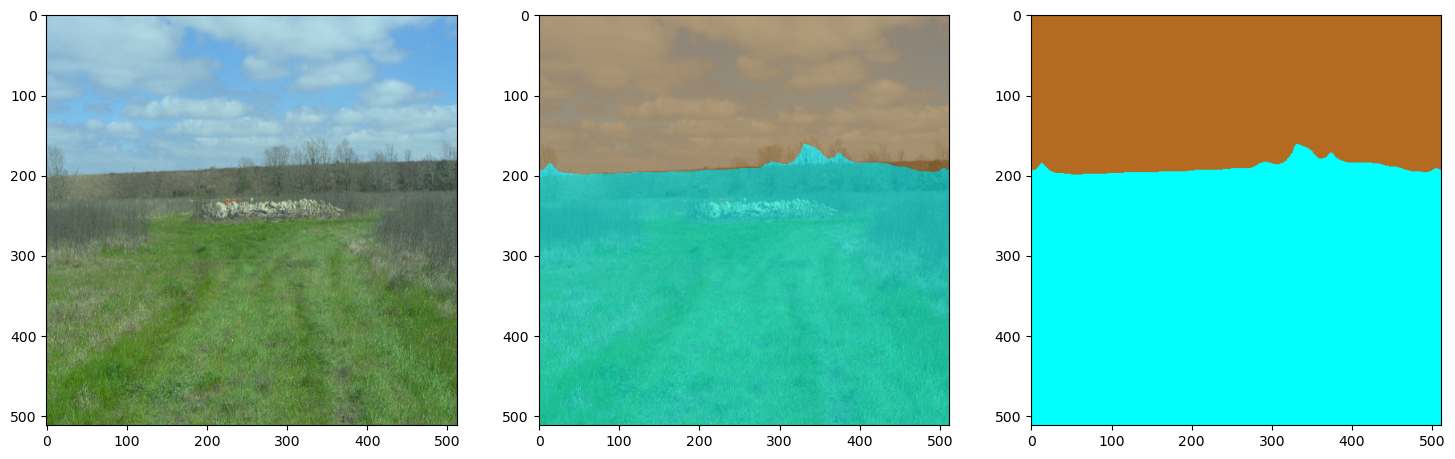

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


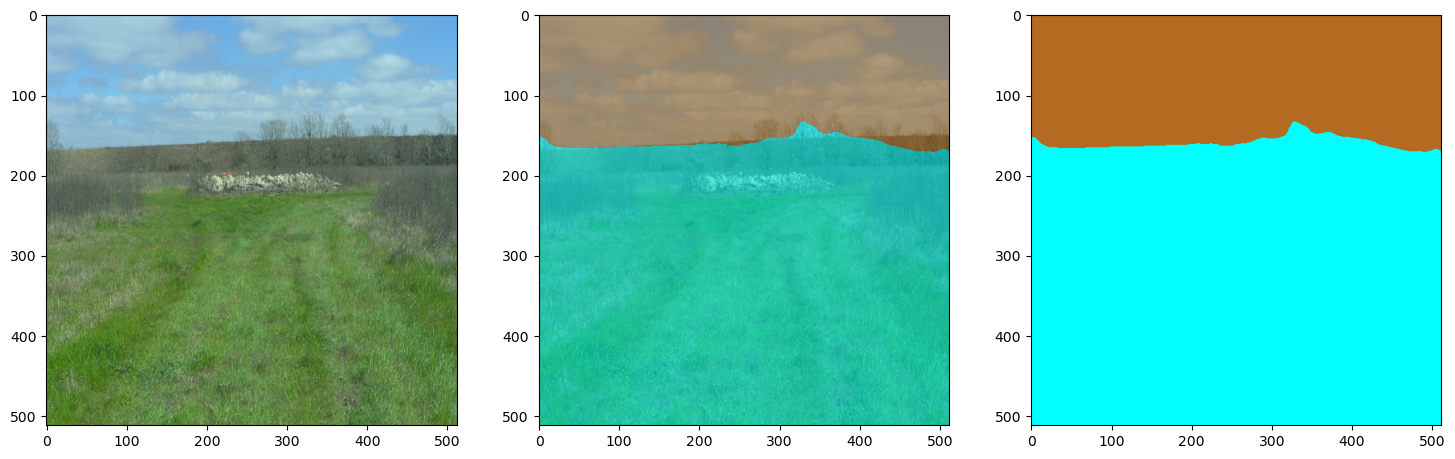

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


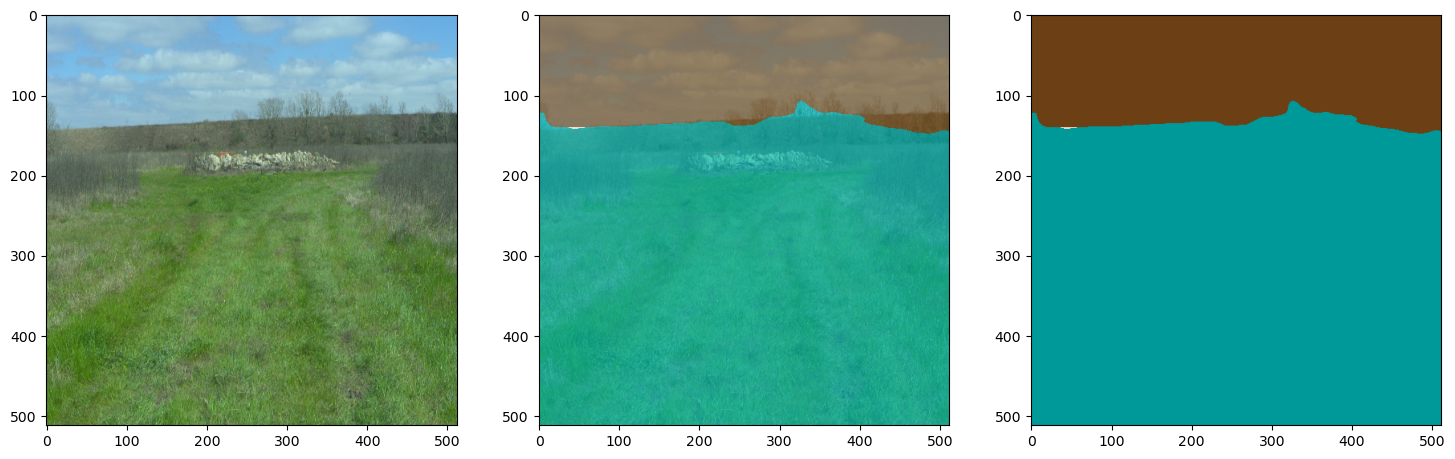

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


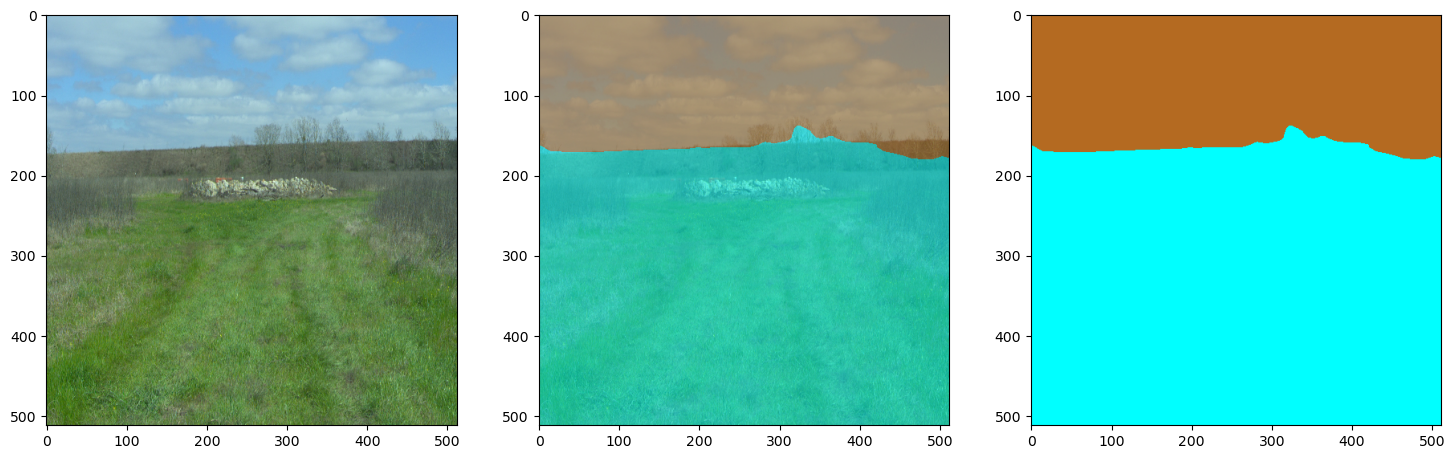

 RGB image - RGB with predicted overlay - Predicted mask 


In [23]:
plot_predictions(val_images[:4], PALETTE, model=model)
print(' RGB image - RGB with predicted overlay - Predicted mask ')

['./rellis6\\GT_test\\frame000000-1581623790_349.png', './rellis6\\GT_test\\frame000000-1581624652_750.png', './rellis6\\GT_test\\frame000002-1581623790_549.png', './rellis6\\GT_test\\frame000002-1581624652_949.png']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
(512, 512, 3)


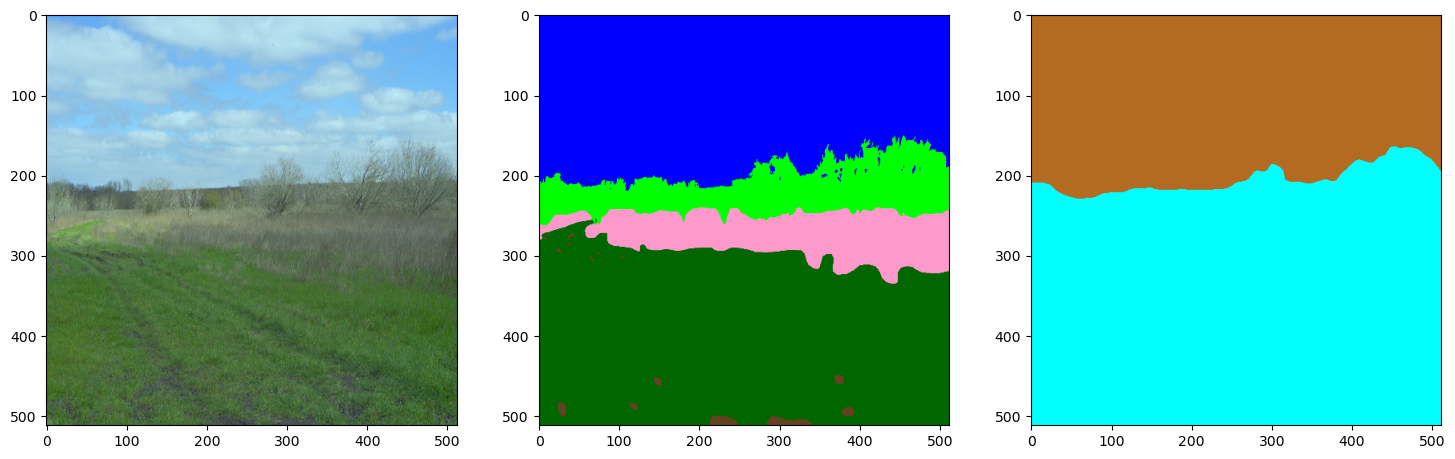

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
(512, 512, 3)


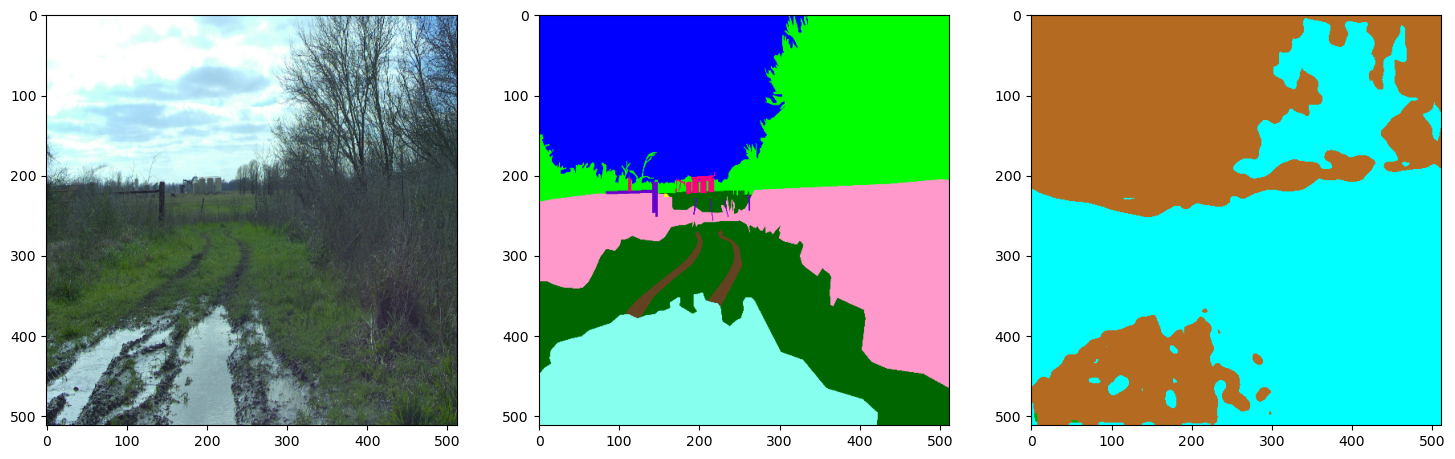

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
(512, 512, 3)


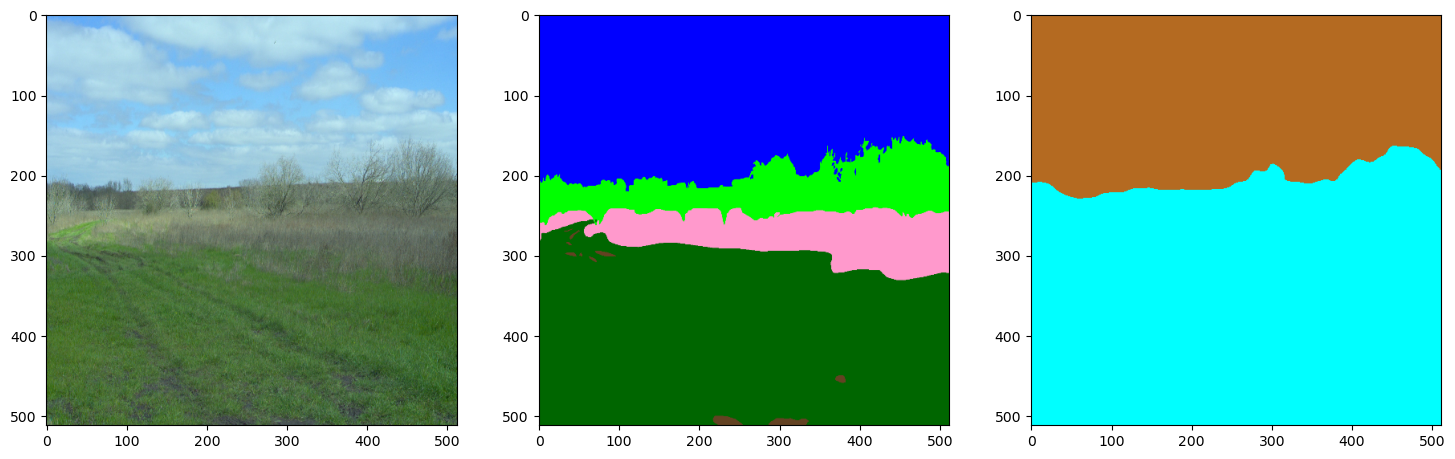

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
(512, 512, 3)


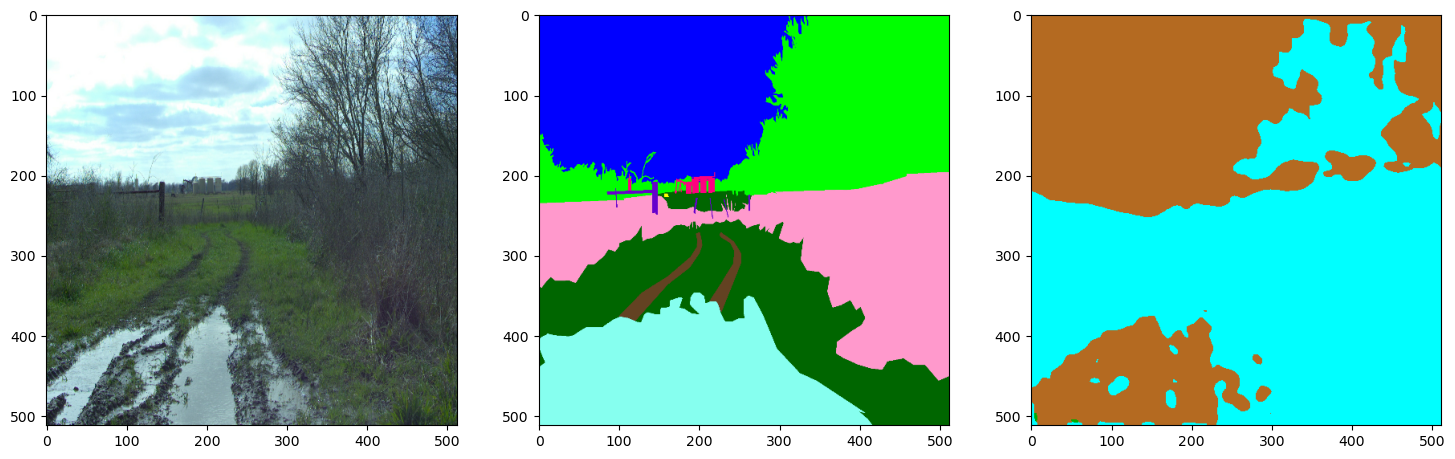

 RGB image - Maskcolor Ground Truth - Maskcolor Predicted 


In [24]:
plot_GTMaskvsPred(test_images[:4], test_gt, test_masks[:4],model=model)
print(' RGB image - Maskcolor Ground Truth - Maskcolor Predicted ')

## Guardar modelo con predicciones

In [25]:
tf.saved_model.save(model, './model/Test_4.1_DeepLabV3+_Rellis6_pred')

INFO:tensorflow:Assets written to: ./model/Test_4.1_DeepLabV3+_Rellis6_pred\assets


INFO:tensorflow:Assets written to: ./model/Test_4.1_DeepLabV3+_Rellis6_pred\assets
